In [1]:
# Importing Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Load Files

In [2]:
test = pd.read_csv('../stage3/test_student.txt', sep=' ', header=None, index_col=0)
test.columns = ['cab_file', 'start_latitude', 'start_longitude', 'source_timestamp', 'end_latitude', 'end_longitude']
test['source_timestamp'] = pd.to_datetime(test['source_timestamp'], unit='s')
test.head()

,cab_file,start_latitude,start_longitude,source_timestamp,end_latitude,end_longitude
0,,,,,,
0,edf177ee-7e81-4785-821e-ac3d13094ec9.txt,37.61564,-122.39190,2008-06-09 16:57:34,37.78373,-122.40747
1,edf177ee-7e81-4785-821e-ac3d13094ec9.txt,37.62060,-122.39936,2008-06-09 16:19:15,37.74579,-122.41056
2,edf177ee-7e81-4785-821e-ac3d13094ec9.txt,37.76160,-122.43947,2008-06-09 14:55:29,37.61486,-122.38584
3,edf177ee-7e81-4785-821e-ac3d13094ec9.txt,37.76731,-122.43667,2008-06-09 14:00:35,37.61791,-122.38583
4,edf177ee-7e81-4785-821e-ac3d13094ec9.txt,37.78554,-122.40636,2008-06-09 13:06:06,37.61786,-122.38543


In [3]:
train = pd.read_csv('../stage3/outputs/All_Taxi_Trips.csv')
train.head()

,trip_id,start_latitude,start_longitude,source_timestamp,origin_point,end_latitude,end_longitude,destination_timestamp,destination_point,cab_id
0,1,37.96943,-122.31778,2008-05-17 15:20:33,"(37.96943, -122.31778)",37.79119,-122.40449,2008-05-17 15:40:50,"(37.79119, -122.40449)",0
1,2,37.79505,-122.40479,2008-05-17 15:41:28,"(37.79505, -122.40479)",37.78362,-122.40262,2008-05-17 15:46:48,"(37.78362, -122.40262)",0
2,3,37.78363,-122.40261,2008-05-17 15:46:49,"(37.78363, -122.40261)",37.79552,-122.40463,2008-05-17 15:51:49,"(37.79552, -122.40463)",0
3,4,37.79593,-122.40495,2008-05-17 15:52:36,"(37.79593, -122.40495)",37.80647,-122.42048,2008-05-17 15:59:31,"(37.80647, -122.42048)",0
4,5,37.80648,-122.42048,2008-05-17 15:59:39,"(37.80648, -122.42048)",37.80052,-122.43030,2008-05-17 16:16:11,"(37.80052, -122.4303)",0


In [4]:
# Preprocess Data
# make trip length variable
train['destination_timestamp'] = pd.to_datetime(train['destination_timestamp'])
train['source_timestamp'] = pd.to_datetime(train['source_timestamp'])
train['trip_length'] = train['destination_timestamp'] - train['source_timestamp']
y = pd.to_timedelta(train['trip_length'], unit='s').dt.total_seconds()
y = y.apply(np.log)
y.head()

0    7.104144
1    5.768321
2    5.703782
3    6.028279
4    6.899723
Name: trip_length, dtype: float64

In [5]:
# drop unnecessary columns
X = train[['start_latitude', 'start_longitude', 'end_latitude', 'end_longitude', 'cab_id', 'source_timestamp']].copy()

# generate time series parameters
X['hour'] = X['source_timestamp'].dt.hour
X['minute'] = X['source_timestamp'].dt.minute
X['second'] = X['source_timestamp'].dt.second
X['weekday'] = X['source_timestamp'].dt.weekday
X['day_of_year'] = X['source_timestamp'].dt.dayofyear
X['cab_id'] = X['cab_id'].astype('category')

# drop timestamp
X.drop('source_timestamp', axis=1, inplace=True)

X.head()


,start_latitude,start_longitude,end_latitude,end_longitude,cab_id,hour,minute,second,weekday,day_of_year
0,37.96943,-122.31778,37.79119,-122.40449,0,15,20,33,5,138
1,37.79505,-122.40479,37.78362,-122.40262,0,15,41,28,5,138
2,37.78363,-122.40261,37.79552,-122.40463,0,15,46,49,5,138
3,37.79593,-122.40495,37.80647,-122.42048,0,15,52,36,5,138
4,37.80648,-122.42048,37.80052,-122.43030,0,15,59,39,5,138


In [6]:
# Make Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


In [7]:
model = lgb.LGBMRegressor()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# calculate R-squared score
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("R-squared score:", r2)


R-squared score: 0.4585781016261462


In [8]:
X_test.columns

Index(['start_latitude', 'start_longitude', 'end_latitude', 'end_longitude',
       'cab_id', 'hour', 'minute', 'second', 'weekday', 'day_of_year'],
      dtype='object')

# Lazy Learn

In [9]:
from lazypredict.Supervised import LazyRegressor
lazy_reg = LazyRegressor(predictions=True)
models, predictions = lazy_reg.fit(X_train, X_test, y_train, y_test)

100%|██████████| 42/42 [20:02<00:00, 28.64s/it] 


In [10]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
XGBRegressor,0.50,0.50,0.77,1.73
RandomForestRegressor,0.50,0.50,0.77,63.77
ExtraTreesRegressor,0.49,0.49,0.78,29.51
LGBMRegressor,0.48,0.48,0.78,0.19
HistGradientBoostingRegressor,0.47,0.47,0.79,0.66
BaggingRegressor,0.44,0.44,0.81,8.38
NuSVR,0.36,0.37,0.87,533.46
SVR,0.36,0.36,0.87,454.98
GradientBoostingRegressor,0.35,0.35,0.88,16.26


# FeatureWiz

wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        
############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Regression problem ####
    Loaded train data. Shape = (98647, 11)
#### Single_Label Regression problem ####
No test data filename given...
Classifying features using a random sample of 10000 rows from dataset...
#

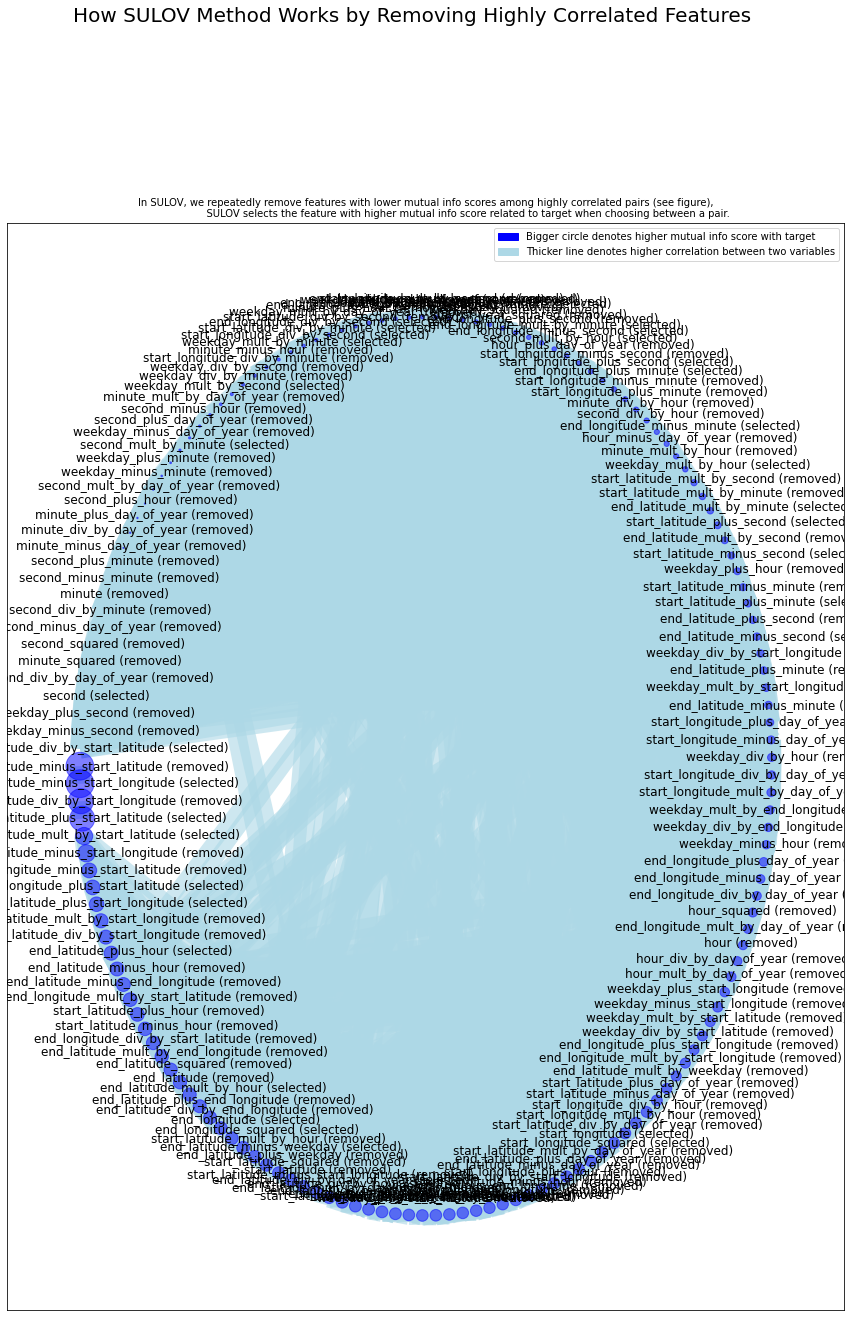

Time taken for SULOV method = 85 seconds
    Adding 1 categorical variables to reduced numeric variables  of 42
Finally 43 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
    there were no mixed data types or object columns that errored. Data is all numeric...
Shape of train data after adding missing values flags = (98647, 53)
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Since ['interactions'] category encoding is done, dropping original categorical vars from predictors...
    Taking top 32 features per iteration...
    XGBoost version using 1.7.5 as tree method: hist
Number of booster rounds = 100
            Time taken for regular XGBoost feature selection = 7 seconds
        Selected: ['start_longitud

['end_latitude_div_by_start_latitude',
 'end_longitude_minus_start_longitude',
 'end_latitude_mult_by_start_latitude',
 'end_longitude',
 'end_latitude_plus_start_latitude',
 'end_latitude_div_by_hour',
 'end_latitude_plus_start_longitude',
 'end_longitude_div_by_hour',
 'start_longitude_squared',
 'end_longitude_plus_start_latitude',
 'end_latitude_plus_hour',
 'end_longitude_minus_hour',
 'end_latitude_div_by_weekday',
 'end_latitude_div_by_day_of_year',
 'end_latitude_minus_weekday',
 'end_latitude_minus_minute',
 'weekday_div_by_end_longitude',
 'end_latitude_minus_second',
 'weekday_mult_by_hour',
 'end_latitude_div_by_second',
 'second_mult_by_hour',
 'end_longitude_plus_minute',
 'start_latitude_plus_minute',
 'start_latitude_plus_second',
 'end_latitude_div_by_minute',
 'end_longitude_minus_second',
 'weekday_mult_by_second',
 'start_latitude_div_by_minute',
 'weekday_mult_by_minute',
 'start_latitude_minus_second',
 'second_mult_by_minute',
 'end_longitude_minus_minute',
 'end

In [14]:
import lightgbm as lgb
from featurewiz import FeatureWiz

# feature engineering and selection with featurewiz
features = FeatureWiz(corr_limit=0.70, feature_engg='interactions', category_encoders='',
dask_xgboost_flag=False, nrows=None, verbose=1)

X_train_selected = features.fit_transform(X_train, y_train)
X_test_selected = features.transform(X_test)
features.features

In [15]:
X_train_selected.head()

,end_latitude_div_by_start_latitude,end_longitude_minus_start_longitude,end_latitude_mult_by_start_latitude,end_longitude,end_latitude_plus_start_latitude,end_latitude_div_by_hour,end_latitude_plus_start_longitude,end_longitude_div_by_hour,start_longitude_squared,end_longitude_plus_start_latitude,...,start_longitude_plus_second,end_longitude_div_by_second,end_latitude_div_by_hour,end_latitude_div_by_weekday,start_longitude_div_by_second,end_longitude_mult_by_minute,end_longitude_div_by_minute,second,end_longitude_div_by_minute,trip_length
33023,1.00,0.01,1427.01,-122.43,75.55,1.89,-84.66,-6.12,14991.01,-84.66,...,-121.44,-122.43,1.89,7.56,-122.44,-244.87,-61.22,1,-61.22,5.97
9088,1.00,0.02,1426.10,-122.42,75.53,6.29,-84.69,-20.40,14990.89,-84.64,...,-111.44,-11.13,6.29,7.55,-11.13,-6977.90,-2.15,11,-2.15,8.28
11765,1.00,0.05,1427.13,-122.39,75.55,7.56,-84.66,-24.48,14991.03,-84.62,...,-115.44,-17.48,7.56,18.89,-17.49,-2203.07,-6.80,7,-6.80,6.58
24200,1.00,-0.02,1421.33,-122.41,75.40,1.89,-84.60,-6.12,14978.64,-84.79,...,-106.39,-7.65,1.89,9.45,-7.65,-4651.46,-3.22,16,-3.22,7.50
2928,1.00,0.00,1429.01,-122.44,75.60,2.10,-84.64,-6.80,14991.97,-84.64,...,-64.44,-2.11,2.10,6.30,-2.11,-2571.27,-5.83,58,-5.83,4.08


In [16]:
model = lgb.LGBMRegressor()

model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)

# calculate R-squared score
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("R-squared score:", r2)


[LightGBM] [Fatal] Feature (end_latitude_div_by_hour) appears more than one time.


LightGBMError: Feature (end_latitude_div_by_hour) appears more than one time.

# Optuna

In [ ]:
import optuna
from optuna.samplers import TPESampler


# perform lightgbm hyperparameter tuning with optuna
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'r2',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2


sampler = TPESampler(seed=123)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=500)

In [ ]:
study.best_value

In [ ]:
best_params = study.best_params
best_params

In [ ]:
X_test.columns

In [ ]:
best_model = lgb.LGBMRegressor(**best_params)
best_model.fit(X_train, y_train)

# Final Model Predictions

In [ ]:

import pickle

# load taxi dictionary
with open('../stage3/outputs/Taxi_Dictionary.pkl', 'rb') as handle:
    taxi_dict = pickle.load(handle)

taxi_dict = {value: key for key, value in taxi_dict.items()}

print(taxi_dict)

In [ ]:
# load cab file to id dictionary
test['cab_id'] = test['cab_file'].map(taxi_dict)


In [ ]:
# generate time series parameters
X_test = test[
    ['start_latitude', 'start_longitude', 'end_latitude', 'end_longitude', 'cab_id', 'source_timestamp']].copy()

# generate time series parameters
X_test['hour'] = X_test['source_timestamp'].dt.hour
X_test['second'] = X_test['source_timestamp'].dt.second
X_test['minute'] = X_test['source_timestamp'].dt.minute
X_test['weekday'] = X_test['source_timestamp'].dt.weekday
X_test['day_of_year'] = X_test['source_timestamp'].dt.dayofyear
X_test['cab_id'] = X_test['cab_id'].astype('category')
# drop timestamp
X_test.drop('source_timestamp', axis=1, inplace=True)

X_test.head()
X_test.head()
X_test.info()

In [ ]:
X_train.columns

In [117]:

y_pred = best_model.predict(X_test)
y_pred = pd.DataFrame(y_pred)
y_pred = y_pred.apply(np.exp)
y_pred.head()
y_pred.to_csv('../outputs/lightgbm.csv', header=False, index=False)